# Environmental settings
###1. Lib: mdbtools
   - https://github.com/mdbtools/mdbtools

###2. Google drive connection: for accessing electrophoresis mdb files


In [ ]:
# mdbtools
!apt-get install mdbtools

# Google drive
from google.colab import drive
import os
drive.mount('/content/drive')
%cd ./drive/MyDrive/sebia_IFE/

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libmdb2 libmdbsql2
Suggested packages:
  mdbtools-doc bash-completion
The following NEW packages will be installed:
  libmdb2 libmdbsql2 mdbtools
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 108 kB of archives.
After this operation, 436 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libmdb2 amd64 0.7.1-6build1 [46.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libmdbsql2 amd64 0.7.1-6build1 [22.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 mdbtools amd64 0.7.1-6build1 [39.0 kB]
Fetched 108 kB in 0s (520 kB/s)
Selecting previously unselected package libmdb2:amd64.
(Reading database ... 122545 files and directories currently installed.)
Preparing to unpack .../libmdb2_0.7.1-6build1_amd64.deb ...
Unpacking libmdb2:amd

# The class "IFE"
## Main features
 - Simple data preprocessing (into various pandas dataframes)
 - Basic operations for simple specimen
  - Specific specimen search
  - Result illustration
  - Searching special (potentially problematic) specimens

In [ ]:
import subprocess
import csv
import pandas as pd
import functools as ft
import matplotlib.pyplot as plt

class IFE():
  def __init__(self, mdbfiles_list):
    self.mdbfiles_list = mdbfiles_list

  ###### PART 1. 資料前處理，返回不同型態的 Dataframe ######
  
  # dataframe: 把不同批次的mdb串成單一 pd.Dataframe
  def dataframe(self):
    dataframe_list = []
    for mdbfile in self.mdbfiles_list:
      # mdb-export: 將mdb檔案轉為csv格式 (bytes type)
      command = f"mdb-export {mdbfile} Anagrafica"
      output = subprocess.check_output(command, shell=True)
      output_str = output.decode("utf-8")
      # 將csv檔案轉為 2Dlist ，再轉為 pd.Dataframe
      csv_reader = csv.reader(output_str.splitlines())
      csv_reader_list = list(csv_reader)
      dataframe_list.extend(csv_reader_list)
    complete_dataframe = pd.DataFrame( dataframe_list[1:], columns = dataframe_list[0])
    return complete_dataframe

  # key_feature_dataframe:
  # 1. 只留下訓練用的features: data_analisi, curva, originalcurve, longmemo, num, ab
  # 2. 去除品管檢體
  def key_feature_dataframe(self):
    complete_dataframe = self.dataframe()[['data_analisi', 'id', 'curva', 'originalcurve', 'longmemo']]
    # 利用院內檢體編號規則，去除品管檢體。
    complete_dataframe = complete_dataframe.loc[ complete_dataframe['id'].str.startswith('I3') ] 
    complete_dataframe['num'] = complete_dataframe['id'].str[:11]
    complete_dataframe['ab'] = complete_dataframe['id'].str[-1]
    complete_dataframe = complete_dataframe.drop(columns = ['id'])
    return complete_dataframe

  # sorted_dataframe:
  # 把原本database的資料集格式修改，變成一筆檢體一筆資料
  def sorted_dataframe(self):
    key_dataframe = self.key_feature_dataframe()
    # 去掉空字串，剩下的資料為 ELP panel：所有comment都存放於該筆資料
    sorted_dataframe = key_dataframe.loc[ key_dataframe['longmemo'].str.strip() != "" ]
    sorted_dataframe.rename(columns = {'curva': 'curva_P','originalcurve': 'originalcurve_P'}, inplace=True)
    sorted_dataframe = sorted_dataframe.reindex(columns = sorted_dataframe.columns.tolist() + ['curva_G', 'originalcurve_G', 'curva_A', 'originalcurve_A', 'curve_M', 'originalcurve_M', 'curva_K', 'originalcurve_K', 'curva_L', 'originalcurve_L'])

    # 篩選出所有檢體編號
    nonempty_specimen_set = set(sorted_dataframe['num'].tolist())
    typical_amount_specimen_set = set(self.typical_amount_specimen())
    atypical_amount_specimen_set = set(self.atypical_amount_specimen())
    typical_amount_specimen_set = (typical_amount_specimen_set & nonempty_specimen_set)
    atypical_amount_specimen_set = (atypical_amount_specimen_set & nonempty_specimen_set)


    for specimen in typical_amount_specimen_set:
      for antisera in ["G", "A", "M", "K", "L"]:
        # 從原本的 key_dataframe 找出檢體的GAMKL序列，填回去sorted_dataframe的新欄位
        # 因為mdb檔案的資料排列沒有依照順序，所以不可以用固定的規則去推算行數，必須要直接查找 (也為了避免不可預期的錯誤)
        simple_row_num = sorted_dataframe[sorted_dataframe['num'] == specimen].index.values[0]
        key_row_num = key_dataframe[(key_dataframe['num'] == specimen) & (key_dataframe['ab'] == antisera)].index.values[0]
        sorted_dataframe.at[simple_row_num, f'curva_{antisera}'] = key_dataframe.at[key_row_num, 'curva']
        sorted_dataframe.at[simple_row_num, f'originalcurve_{antisera}'] = key_dataframe.at[key_row_num, 'originalcurve']

    atypical_amount_key_dataframe = key_dataframe.loc[ key_dataframe['num'].isin(atypical_amount_specimen_set) ]
    for specimen in atypical_amount_specimen_set:
      timestamp_list = self.atypical_key_feature_dataframe()[ self.atypical_key_feature_dataframe()["num"] == specimen ]['data_analisi'].value_counts().index
      for timestamp in timestamp_list:
        for antisera in ["G", "A", "M", "K", "L"]:
          # atypcial 目前已知識出現於檢體重做的狀況，所以對兩個標籤：data_analisi & num
          simple_row_num = sorted_dataframe[(sorted_dataframe['num'] == specimen) & (sorted_dataframe['data_analisi'] == timestamp)].index.values[0]
          key_row_num = atypical_amount_key_dataframe[(atypical_amount_key_dataframe['num'] == specimen) & (atypical_amount_key_dataframe['ab'] == antisera) & (atypical_amount_key_dataframe['data_analisi'] == timestamp)].index.values[0]
          sorted_dataframe.at[simple_row_num, f'curva_{antisera}'] = key_dataframe.at[key_row_num, 'curva']
          sorted_dataframe.at[simple_row_num, f'originalcurve_{antisera}'] = key_dataframe.at[key_row_num, 'originalcurve']
    return sorted_dataframe

  ###### PART 1.1 特定條件的檢體 Dataframe，及其衍生函數 ######
  # 所有子集都以 key_feature_dataframe 的型態作為返回值

  # 典型的檢體，一筆檢體號對應到六行(六條曲線)
  def typical_amount_specimen(self): # 返回 index 物件
    key_dataframe = self.key_feature_dataframe()
    specimen_data_num = key_dataframe["num"].value_counts()
    typical_key_dataframe = specimen_data_num[ specimen_data_num.values == 6 ]
    return typical_key_dataframe.index

  # 非典型檢體
  # 可能是同一筆檢體上機n次，會有 6*n 條曲線：處理這種檢體需要納入"data_analisi"進一步作區別
  # 也以防有非6倍數的情況出現(目前未曾出現)
  def atypical_amount_specimen(self): # 返回 index 物件
    key_dataframe = self.key_feature_dataframe()
    specimen_data_num = key_dataframe["num"].value_counts()
    atypical_key_dataframe = specimen_data_num[ specimen_data_num.values != 6 ]
    return atypical_key_dataframe.index

  def atypical_key_feature_dataframe(self):
    key_dataframe = self.key_feature_dataframe()
    specimen_data_num = key_dataframe["num"].value_counts()
    atypical_key_dataframe = specimen_data_num[ specimen_data_num.values != 6 ]
    return key_dataframe.loc[ key_dataframe['num'].isin(atypical_key_dataframe.index) ]

  # 找出沒有comment的檢體們
  def empty_key_feature_dataframe(self):
    key_dataframe = self.key_feature_dataframe()
    empty_specimen_ELP = key_dataframe.loc[ (key_dataframe['longmemo'].str.strip() == "") & (key_dataframe['ab'] == "P")]
    empty_specimen_names = list(empty_specimen_ELP["num"])
    condition_string = "|".join( empty_specimen_names )
    print(condition_string)
    # 請參考 pandas內str.contains()文檔，有針對多個字串查找的示範
    empty_dataframe = key_dataframe.loc[ key_dataframe['num'].str.contains(condition_string) ]
    return empty_dataframe


  ###### PART 2. 個別檢體操作 ######  
  @staticmethod
  def search_from_df(df, specimen):
    try:
      return df.loc[ df["num"].str.startswith(specimen) ]
    except KeyError:
      return df.loc[ df["id"].str.startswith(specimen) ]

  def search(self, specimen):
    key_dataframe = self.key_feature_dataframe()
    return key_dataframe.loc[ key_dataframe["num"].str.startswith(specimen) ]

  @staticmethod
  def intensity(sebia_curva):
    intensity_list = []
    for time in range(0,300):
      hex_intensity = sebia_curva[1+4*time : 4+4*time]
      dec_intensity = int(hex_intensity, 16)
      intensity_list.append(dec_intensity)
    return intensity_list

  def plot(self, specimen):
    specimen_df = self.search(specimen)
    antisera_list = ["P", "G", "A", "M", "K", "L"]
    # 先把ELP的資料叫出來，作為疊圖使用
    curva_text_P = list( specimen_df[ specimen_df["ab"] == "P" ]["curva"] )[0] #對於同樣檢體有多條曲線者，此步驟需要修改
    intensity_P = IFE.intensity(curva_text_P)
    intensity_P.reverse()
    
    fig, ax = plt.subplots(2, 3, figsize = (15, 10))
    for i in range(len(antisera_list)):
      curva_text = list( specimen_df[ specimen_df["ab"] == antisera_list[i] ]["curva"] )[0]
      intensity = IFE.intensity(curva_text)
      # 電泳的訊號需要倒過來
      intensity.reverse()
      ax[i//3, i%3].plot(intensity)
      ax[i//3, i%3].plot(intensity_P)
    plt.show()

# Demostration (of key functions)
##1. Preprocessed dataframes
 - Two main types of dataframe: curve-based vs specimen-based dataframe

In [ ]:
test = IFE(['20230401.mdb', '20230402.mdb'])
# key_feature_dataframe(): one row per curve
test.key_feature_dataframe()

,data_analisi,curva,originalcurve,longmemo,num,ab
12,04/06/23 00:00:00,801E001E001E001E001E001E001E001E001E001E001E00...,828E028E028D028B028A02890289028D028B028B028B02...,No monoclonal protein present.;,I3033100519,P
13,04/06/23 00:00:00,8000000000000000000000000000000000000000000000...,8231023002300230022F022E022E022F022F022E022E02...,,I3033100519,G
14,04/06/23 00:00:00,8000000000000000000000000000000000000000000000...,82F302F302EF02EE02ED02EC02ED02EC02ED02EC02EA02...,,I3033100519,A
15,04/06/23 00:00:00,8000000000000000000000000000000000000000000000...,82A302A102A0029F029E029C029C029C029D029D029C02...,,I3033100519,M
16,04/06/23 00:00:00,8000000000000000000000000000000000000000000000...,826F026D026E026B026D026D026D026D026D026D026B02...,,I3033100519,K
...,...,...,...,...,...,...
2060,04/14/23 00:00:00,8000000000000000000000000000000000000000000000...,81E601E501E601E601E601E501E501E501E501E501E501...,,I3041472518,M
2061,04/14/23 00:00:00,8000000000000000000000000000000000000000000000...,8189018901880188018901890188018901880188018801...,,I3041472851,G
2062,04/14/23 00:00:00,8000000000000000000000000000000000000000000000...,81B301B201B101B101B101B001B001B101B001B001B001...,,I3041472851,M
2063,04/14/23 00:00:00,8000000000000000000000000000000000000000000000...,8183018301830182018301810180018201820181018201...,,I3041472851,K


In [ ]:
# sorted_dataframe(): one row per speciemen
test.sorted_dataframe()

<ipython-input-6-3f7cf44c79da>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_dataframe.rename(columns = {'curva': 'curva_P','originalcurve': 'originalcurve_P'}, inplace=True)


,data_analisi,curva_P,originalcurve_P,longmemo,num,ab,curva_G,originalcurve_G,curva_A,originalcurve_A,curve_M,originalcurve_M,curva_K,originalcurve_K,curva_L,originalcurve_L,curva_M
12,04/06/23 00:00:00,801E001E001E001E001E001E001E001E001E001E001E00...,828E028E028D028B028A02890289028D028B028B028B02...,No monoclonal protein present.;,I3033100519,P,8000000000000000000000000000000000000000000000...,8231023002300230022F022E022E022F022F022E022E02...,8000000000000000000000000000000000000000000000...,82F302F302EF02EE02ED02EC02ED02EC02ED02EC02EA02...,NaN,82A302A102A0029F029E029C029C029C029D029D029C02...,8000000000000000000000000000000000000000000000...,826F026D026E026B026D026D026D026D026D026D026B02...,8000000000000000000000000000000000000000000000...,8278027802770275027402710271027202740272027102...,8000000000000000000000000000000000000000000000...
18,04/06/23 00:00:00,8000000000000000000000000000000000000000000000...,81FD01FD01FC01FB01FA01FA01F801F801FA01F801F701...,A monoclonal IgG-kappa;protein is identified.;,I3033101608,P,8000000000000000000000000000000000000000000000...,81BB01BC01BC01BB01BB01BC01BB01BB01BB01BB01BC01...,8000000000000000000000000000000000000000000000...,81F901F901F901F801F701F701F701F701FA01FA01F801...,NaN,81D501D501D501D401D301D301D301D401D401D301D301...,8000000000000000000000000000000000000000000000...,8175017301730172017101710171017201720171017001...,8000000000000000000000000000000000000000000000...,81A501A501A501A401A301A301A301A201A301A301A301...,800B000B000B000B000B000B000B000B000B000B000B00...
24,04/06/23 00:00:00,8005000500050005000500050005000500050005000500...,8145014601450144014401440145014401450145014501...,No monoclonal protein present.;,I3033101633,P,8000000000000000000000000000000000000000000000...,813B013D013D013B013B013B013A013A013B013B013D01...,8000000000000000000000000000000000000000000000...,8176017601760176017501750176017501750175017501...,NaN,817101700170017001700170016E016E016E016E016E01...,8000000000000000000000000000000000000000000000...,813D013D013D013D013D013D013C013C013D013D013E01...,8000000000000000000000000000000000000000000000...,8142014201410140014001400140014001400142014201...,8000000000000000000000000000000000000000000000...
30,04/06/23 00:00:00,8000000000000000000000000000000000000000000000...,81F501F501F301F301F301F201F101F101F101F101F101...,No monoclonal protein present.;,I3033104028,P,8000000000000000000000000000000000000000000000...,81A001A0019F019F019E019F019E019E019F019F01A001...,8000000000000000000000000000000000000000000000...,81C801C901C901C801C801C801C601C601C801C801C901...,NaN,81C201C301C301C301C001C001C101C101C201C301C301...,8000000000000000000000000000000000000000000000...,8184018401840184018201820182018201830183018301...,8000000000000000000000000000000000000000000000...,81D501D701D701D701D501D501D401D401D501D501D501...,8008000800080008000800080008000800080008000800...
36,04/06/23 00:00:00,8011001100110011001100110011001100110011001100...,81CF01CF01CF01CF01CE01CE01CF01CF01CF01CF01CF01...,No monoclonal protein present.;,I3033104037,P,8000000000000000000000000000000000000000000000...,819D019B019B019A019A019B019B019B019D019D019D01...,8000000000000000000000000000000000000000000000...,81DB01DB01DA01D901DA01D901D901D901D901D901D801...,NaN,81B301B301B301B201B101B201B101B001B001B001AF01...,8000000000000000000000000000000000000000000000...,8186018601860184018501860185018501860185018501...,8000000000000000000000000000000000000000000000...,81B001AF01AE01AE01AF01AF01AE01AE01AE01AE01AE01...,8000000000000000000000000000000000000000000000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,04/14/23 00:00:00,800F000F000F000F000F000F000F000F000F000F000F00...,817E017E017D017E017E017E017E017E017D017D017E01...,No monoclonal protein present.;,I3041401506,P,8000000000000000000000000000000000000000000000...,8163016401640164016401640163016301630162016201...,8000000000000000000000000000000000000000000000...,81AC01AD01AB01A901A901AB01AC01AC01A901AB01AC01...,NaN,817

##2. Basic operations
 - Two prominent application: search & plot

In [ ]:
test.search("I3040676153")

,data_analisi,curva,originalcurve,longmemo,num,ab
564,04/07/23 00:00:00,8008000800080008000800080008000800080008000800...,8236023502350234023402350234023402340234023502...,BME,I3040676153,P
565,04/07/23 00:00:00,8000000000000000000000000000000000000000000000...,8232023202310231023002310231023002300230023102...,,I3040676153,G
566,04/07/23 00:00:00,8000000000000000000000000000000000000000000000...,8240023D023F023F023F0240023F023F023F023F023F02...,,I3040676153,A
567,04/07/23 00:00:00,8000000000000000000000000000000000000000000000...,8233023102310231023102310230023002300230023102...,,I3040676153,M
568,04/07/23 00:00:00,8000000000000000000000000000000000000000000000...,81C001C001BF01BE01BE01BE01BE01BD01BD01BD01BD01...,,I3040676153,K
569,04/07/23 00:00:00,8000000000000000000000000000000000000000000000...,821B021B021A021A021A02190219021902190219021902...,,I3040676153,L
1454,04/12/23 00:00:00,8018001800180018001800180018001800180018001800...,8238023702360235023402340235023602350235023502...,A monoclonal IgA-kappa;protein is identified.;,I3040676153,P
1455,04/12/23 00:00:00,8000000000000000000000000000000000000000000000...,822B022A022A02280227022702280227022A022A022A02...,,I3040676153,G
1456,04/12/23 00:00:00,8000000000000000000000000000000000000000000000...,81F401F301F301F301F301F301F301F401F401F301F301...,,I3040676153,M
1587,04/12/23 00:00:00,8000000000000000000000000000000000000000000000...,820E020D020A0209020C020C020A020C020C020A020A02...,,I3040676153,A


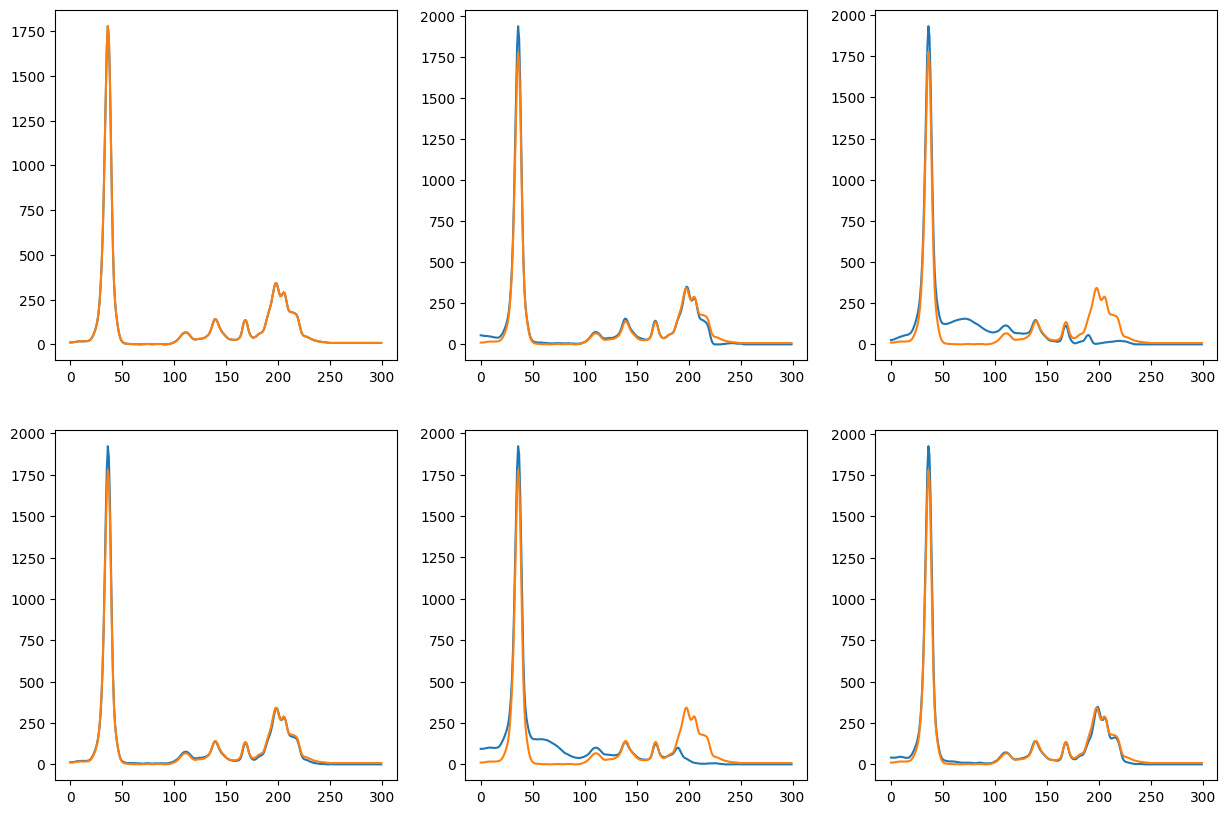

In [ ]:
test.plot("I3040676153")

# Capillary electrophoresis: original data explanation
1. mdb file with seperate batches
2. explanation of key columns in mdb files
 - #0: data_analisi, time of IFE test
 - #9: id, the id of specimen
 - #38: curva, the electrophoresis result
 - #58: longmemo, doctor comments
 - originalcurve, the signal with unknown meaning, some properties are as belows
    - length = 2428
    - 末28碼似乎固定 (0000000008Standard0000100000)
    - [0:1200] 和 [1201:2400] 為兩段分別與curva相似的訊號，十六進制
    - 第4k+1碼可能為8 (curva：除頭尾外皆為0)